In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd 
import numpy as np
import requests
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import parfit.parfit as pf
import time
import dill
from sqlalchemy import create_engine
import sqlalchemy.dialects.sqlite
import pymysql
import matplotlib.pyplot as plt
from mysql_conn import get_mysql_conn

C:\Users\RESCANT\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
con_file = open("connection.txt","r")
user = con_file.readline()
pw = con_file.readline()
host = con_file.readline()
engine = create_engine('mysql+pymysql://'+ user +':' + pw + '@'+ host)

In [3]:
with engine.connect() as con:
    rs = con.execute("SELECT * FROM tech_arescan.2018_pitches")
    raw_data = pd.DataFrame(rs.fetchall())
    raw_data.columns = rs.keys()
con.close()

In [73]:
data = raw_data.copy()

In [74]:
hand_dict = {'R': 0, 'L': 1}
data.throws = data.throws.map(hand_dict)
data.stand = data.stand.map(hand_dict)
extra_info = ['rockies_p','result','des','type','date','ball','strike','pitch_of_ab','pitch_count',
              'batter_position','away_runs','home_runs','outs','half','inning','batter_height',
              'level','park_id','player_position','order_count','batter_count','seq_number',
             'home','height']
ids = ['pitch_id','ab_id','game_id','id','mlbid','batter_mlbid','catcher_mlbid','umpire_id']
data = data.drop(ids,axis=1)
data = data.drop(extra_info, axis=1)
#data = data[(data['wild_pitch'] != 1)]
#data = data[(data['passed_ball'] != 1)]
#data = data.drop('passed_ball', axis=1)
#data = data.drop('result', axis=1)

In [75]:
raw_swing_data = data[(data['swing'] == 'swing')].copy()
raw_swing_data = raw_swing_data.drop('swing',axis=1)

In [76]:
swing_outcome_dict = {'OUT': 0, 'F': 0, '1B': 0, '2B': 0, '3B': 0, 'HR': 0, 'OUT-SAC': 0, 'RBOE' :0, 'NIP': 0, 'S': 1}
raw_swing_data.outcome = raw_swing_data.outcome.map(swing_outcome_dict)

In [77]:
col = ['pi_pitch_type']
raw_swing_data = pd.get_dummies(raw_swing_data,columns=col)

In [78]:
print(raw_swing_data.outcome.value_counts())
raw_swing_data = raw_swing_data.dropna(axis = 0, how='any')
print(raw_swing_data.outcome.value_counts())

0.0    186757
1.0     67191
Name: outcome, dtype: int64
0.0    183760
1.0     65632
Name: outcome, dtype: int64


In [79]:
print(raw_swing_data.columns.values)

['start_speed_corr' 'top_zone' 'bot_zone' 'pfx_x_corr' 'pfx_z_corr'
 'px_corr_new' 'pz_corr_new' 'x0_corr' 'y0_corr' 'z0_corr' 'vx0_corr'
 'vy0_corr' 'vz0_corr' 'ax_corr' 'ay_corr' 'az_corr' 'spin_rate' 'outcome'
 'throws' 'elevation' 'stand' 'rockies_b' 'pi_pitch_type_CH'
 'pi_pitch_type_CU' 'pi_pitch_type_FA' 'pi_pitch_type_FC'
 'pi_pitch_type_FS' 'pi_pitch_type_SL']


In [80]:
print(len(raw_swing_data))

249392


In [81]:
print(data.describe())

       start_speed_corr       top_zone       bot_zone     pfx_x_corr  \
count     541022.000000  541022.000000  541065.000000  541022.000000   
mean          88.382864       3.430630       1.745079      -0.273990   
std            6.110625       0.076974       0.025060       5.407472   
min           48.374200       2.924170       1.661000     -18.492200   
25%           83.847300       3.390400       1.732000      -4.709025   
50%           89.048450       3.426240       1.743830      -0.600523   
75%           93.368500       3.497550       1.767500       3.902920   
max          104.671000       4.363780       1.814830      17.067000   

          pfx_z_corr    px_corr_new    pz_corr_new        x0_corr   y0_corr  \
count  541022.000000  541022.000000  541022.000000  541022.000000  541065.0   
mean        4.127211       0.005517       2.227447      -0.753763      55.0   
std         5.541625       0.857695       0.970454       1.998657       0.0   
min       -20.024800      -4.579710

In [82]:
swing_data = raw_swing_data.copy()

In [83]:
fa_swing_data = swing_data[(swing_data['pi_pitch_type_FA'] == 1)].copy()
ch_swing_data = swing_data[(swing_data['pi_pitch_type_CH'] == 1)].copy()
#cs_swing_data = swing_data[(swing_data['pi_pitch_type_CS'] == 1)].copy()
cu_swing_data = swing_data[(swing_data['pi_pitch_type_CU'] == 1)].copy()
fc_swing_data = swing_data[(swing_data['pi_pitch_type_FC'] == 1)].copy()
fs_swing_data = swing_data[(swing_data['pi_pitch_type_FS'] == 1)].copy()
#kn_swing_data = swing_data[(swing_data['pi_pitch_type_KN'] == 1)].copy()
#sb_swing_data = swing_data[(swing_data['pi_pitch_type_SB'] == 1)].copy()
#si_swing_data = swing_data[(swing_data['pi_pitch_type_SI'] == 1)].copy()
sl_swing_data = swing_data[(swing_data['pi_pitch_type_SL'] == 1)].copy()

pitches = ['pi_pitch_type_CH', 'pi_pitch_type_CU', 'pi_pitch_type_FA', 'pi_pitch_type_FC','pi_pitch_type_FS', 'pi_pitch_type_SL']
fa_swing_data = fa_swing_data.drop(pitches, axis=1)
ch_swing_data = ch_swing_data.drop(pitches, axis=1)
#cs_swing_data = cs_swing_data.drop(pitches, axis=1)
cu_swing_data = cu_swing_data.drop(pitches, axis=1)
fc_swing_data = fc_swing_data.drop(pitches, axis=1)
fs_swing_data = fs_swing_data.drop(pitches, axis=1)
#kn_swing_data = kn_swing_data.drop(pitches, axis=1)
#sb_swing_data = sb_swing_data.drop(pitches, axis=1)
#si_swing_data = si_swing_data.drop(pitches, axis=1)
sl_swing_data = sl_swing_data.drop(pitches, axis=1)

In [84]:
print(len(fa_swing_data.columns.values))
print(len(cu_swing_data.columns.values))
print(len(ch_swing_data.columns.values))
print(len(fc_swing_data.columns.values))
print(len(fs_swing_data.columns.values))
print(len(sl_swing_data.columns.values))

22
22
22
22
22
22


In [95]:
names = ['start_speed_corr', 'top_zone', 'bot_zone', 'pfx_x_corr', 'pfx_z_corr',
 'px_corr_new', 'pz_corr_new', 'x0_corr', 'y0_corr', 'z0_corr', 'vx0_corr',
 'vy0_corr', 'vz0_corr', 'ax_corr', 'ay_corr', 'az_corr', 'spin_rate', 'outcome',
 'throws', 'elevation', 'stand', 'rockies_b']


scale_names = ['start_speed_corr', 'top_zone', 'bot_zone', 'pfx_x_corr', 'pfx_z_corr',
 'px_corr_new', 'pz_corr_new', 'x0_corr', 'y0_corr', 'z0_corr', 'vx0_corr',
 'vy0_corr', 'vz0_corr', 'ax_corr', 'ay_corr', 'az_corr', 'spin_rate']

swing_data = swing_data.loc[:,names].copy()
swing_data[scale_names] = StandardScaler().fit_transform(swing_data[scale_names])

feature_list = ['start_speed_corr', 'top_zone', 'bot_zone', 'pfx_x_corr', 'pfx_z_corr',
 'px_corr_new', 'pz_corr_new', 'x0_corr', 'y0_corr', 'z0_corr', 'vx0_corr',
 'vy0_corr', 'vz0_corr', 'ax_corr', 'ay_corr', 'az_corr', 'spin_rate', 
 'throws', 'elevation', 'stand', 'rockies_b']

fa_swing_data = fa_swing_data.loc[:,names].copy()
fa_swing_data[scale_names] = StandardScaler().fit_transform(fa_swing_data[scale_names])

cu_swing_data = cu_swing_data.loc[:,names].copy()
cu_swing_data[scale_names] = StandardScaler().fit_transform(cu_swing_data[scale_names])

sl_swing_data = sl_swing_data.loc[:,names].copy()
sl_swing_data[scale_names] = StandardScaler().fit_transform(sl_swing_data[scale_names])

ch_swing_data = ch_swing_data.loc[:,names].copy()
ch_swing_data[scale_names] = StandardScaler().fit_transform(ch_swing_data[scale_names])

fs_swing_data = fs_swing_data.loc[:,names].copy()
fs_swing_data[scale_names] = StandardScaler().fit_transform(fs_swing_data[scale_names])

fc_swing_data = fc_swing_data.loc[:,names].copy()
fc_swing_data[scale_names] = StandardScaler().fit_transform(fc_swing_data[scale_names])


C:\Users\RESCANT\AppData\Local\Continuum\anaconda4\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [86]:
y = swing_data.pop('outcome').values
y = np.ravel(y)
print(swing_data.shape)
fa_y = fa_swing_data.pop('outcome').values
fa_y = np.ravel(fa_y)
ch_y = ch_swing_data.pop('outcome').values
ch_y = np.ravel(ch_y)
#cs_y = cs_swing_data.pop('outcome').values
#cs_y = np.ravel(cs_y)
cu_y = cu_swing_data.pop('outcome').values
cu_y = np.ravel(cu_y)
fc_y = fc_swing_data.pop('outcome').values
fc_y = np.ravel(fc_y)
fs_y = fs_swing_data.pop('outcome').values
fs_y = np.ravel(fs_y)
#kn_y = kn_swing_data.pop('outcome').values
#kn_y = np.ravel(kn_y)
#sb_y = sb_swing_data.pop('outcome').values
#sb_y = np.ravel(sb_y)
#si_y = si_swing_data.pop('outcome').values
#si_y = np.ravel(si_y)
sl_y = sl_swing_data.pop('outcome').values
sl_y = np.ravel(sl_y)

(249392, 21)


In [87]:
X_int, X_test, y_int, y_test = train_test_split(swing_data, y,stratify=y,test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_int, y_int,stratify=y_int, test_size=0.25)

del(X_int,y_int)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(y),2),
                                                       round(len(y_val)/len(y),2),
                                                       round(len(y_test)/len(y),2)))

X_int_fa, X_test_fa, y_int_fa, y_test_fa = train_test_split(fa_swing_data, fa_y, stratify=fa_y,test_size=0.2)

X_train_fa, X_val_fa, y_train_fa, y_val_fa = train_test_split(X_int_fa, y_int_fa, stratify=y_int_fa, test_size=0.25)

del(X_int_fa,y_int_fa)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train_fa)/len(fa_y),2),
                                                       round(len(y_val_fa)/len(fa_y),2),
                                                       round(len(y_test_fa)/len(fa_y),2)))

X_int_cu, X_test_cu, y_int_cu, y_test_cu = train_test_split(cu_swing_data, cu_y, stratify=cu_y,test_size=0.2)

X_train_cu, X_val_cu, y_train_cu, y_val_cu = train_test_split(X_int_cu, y_int_cu, stratify=y_int_cu, test_size=0.25)

del(X_int_cu,y_int_cu)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train_cu)/len(cu_y),2),
                                                       round(len(y_val_cu)/len(cu_y),2),
                                                       round(len(y_test_cu)/len(cu_y),2)))

X_int_sl, X_test_sl, y_int_sl, y_test_sl = train_test_split(sl_swing_data, sl_y, stratify=sl_y,test_size=0.2)

X_train_sl, X_val_sl, y_train_sl, y_val_sl = train_test_split(X_int_sl, y_int_sl, stratify=y_int_sl, test_size=0.25)

del(X_int_sl,y_int_sl)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train_sl)/len(sl_y),2),
                                                       round(len(y_val_sl)/len(sl_y),2),
                                                       round(len(y_test_sl)/len(sl_y),2)))

X_int_ch, X_test_ch, y_int_ch, y_test_ch = train_test_split(ch_swing_data, ch_y, stratify=ch_y,test_size=0.2)

X_train_ch, X_val_ch, y_train_ch, y_val_ch = train_test_split(X_int_ch, y_int_ch, stratify=y_int_ch, test_size=0.25)

del(X_int_ch,y_int_ch)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train_ch)/len(ch_y),2),
                                                       round(len(y_val_ch)/len(ch_y),2),
                                                       round(len(y_test_ch)/len(ch_y),2)))

X_int_fc, X_test_fc, y_int_fc, y_test_fc = train_test_split(fc_swing_data, fc_y, stratify=fc_y,test_size=0.2)

X_train_fc, X_val_fc, y_train_fc, y_val_fc = train_test_split(X_int_fc, y_int_fc, stratify=y_int_fc, test_size=0.25)

del(X_int_fc,y_int_fc)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train_fc)/len(fc_y),2),
                                                       round(len(y_val_fc)/len(fc_y),2),
                                                       round(len(y_test_fc)/len(fc_y),2)))

X_int_fs, X_test_fs, y_int_fs, y_test_fs = train_test_split(fs_swing_data, fs_y, stratify=fs_y,test_size=0.2)

X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(X_int_fs, y_int_fs, stratify=y_int_fs, test_size=0.25)

del(X_int_fs,y_int_fs)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train_fs)/len(fs_y),2),
                                                       round(len(y_val_fs)/len(fs_y),2),
                                                       round(len(y_test_fs)/len(fs_y),2)))

train: 0.6% | validation: 0.2% | test 0.2%
train: 0.6% | validation: 0.2% | test 0.2%
train: 0.6% | validation: 0.2% | test 0.2%
train: 0.6% | validation: 0.2% | test 0.2%
train: 0.6% | validation: 0.2% | test 0.2%
train: 0.6% | validation: 0.2% | test 0.2%
train: 0.6% | validation: 0.2% | test 0.2%


In [88]:
logreg_grid = {
    'C': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5,
             1e-4, 1e-3, 1e-2, 1e-1, 1e0,
             1e1, 1e2, 1e3, 1e4, 1e5,
             1e6, 1e7, 1e8, 1e9, 1e10],
    'penalty': ['l2'],
    'n_jobs': [-1],
    'class_weight': ['balanced']}

logreg_paramGrid = ParameterGrid(logreg_grid)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:   11.8s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:   19.0s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:   20.2s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  18 out of  21 | elapsed:   27.1s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.2s finished


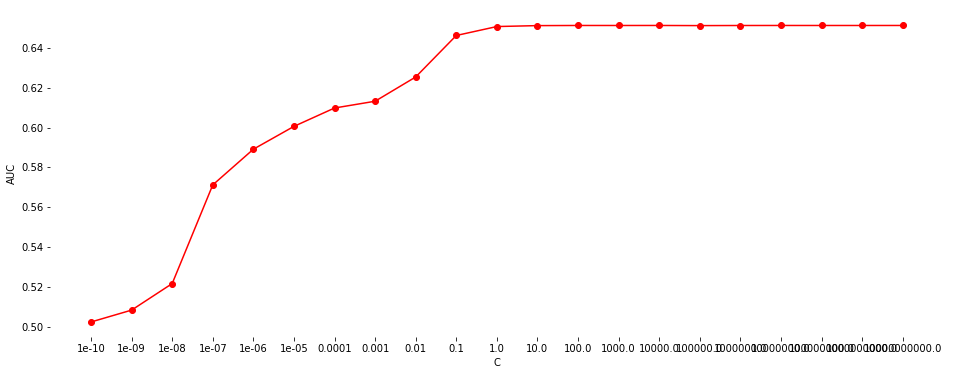

LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.6513482970533814


In [89]:
logreg_models = pf.fitModels(LogisticRegression(), logreg_paramGrid, X_train, y_train)
logreg_scores = pf.scoreModels(logreg_models, X_val, y_val, metric=roc_auc_score, predict_proba=True)
pf.plotScores(logreg_scores, logreg_paramGrid, 'AUC')
logreg_bestModel = pf.getBestModel(logreg_models, logreg_scores, greater_is_better=True)
logreg_bestScore = pf.getBestScore(logreg_scores, greater_is_better=True)
print(logreg_bestModel, logreg_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:    2.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    6.0s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:    6.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  18 out of  21 | elapsed:    8.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.1s finished


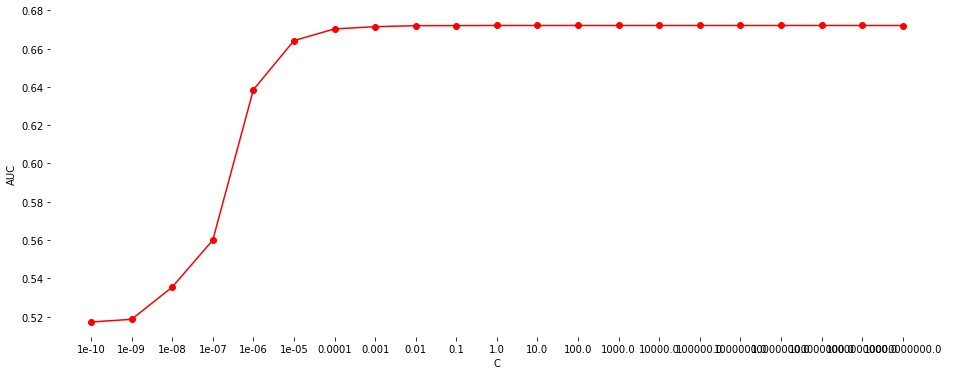

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.6720472388189568


In [90]:
logreg_models = pf.fitModels(LogisticRegression(), logreg_paramGrid, X_train_fa, y_train_fa)
logreg_scores = pf.scoreModels(logreg_models, X_val_fa, y_val_fa, metric=roc_auc_score, predict_proba=True)
pf.plotScores(logreg_scores, logreg_paramGrid, 'AUC')
logreg_bestModel = pf.getBestModel(logreg_models, logreg_scores, greater_is_better=True)
logreg_bestScore = pf.getBestScore(logreg_scores, greater_is_better=True)
print(logreg_bestModel, logreg_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0722s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    1.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.0s finished


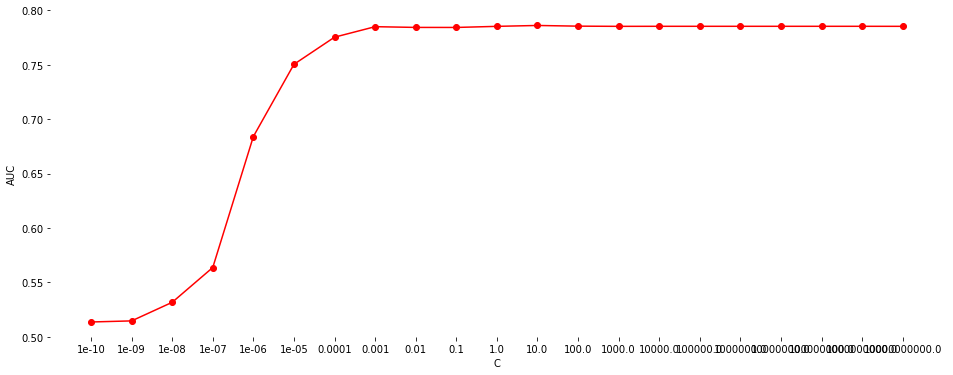

LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.7860944888200251


In [27]:
logreg_models = pf.fitModels(LogisticRegression(), logreg_paramGrid, X_train_cu, y_train_cu)
logreg_scores = pf.scoreModels(logreg_models, X_val_cu, y_val_cu, metric=roc_auc_score, predict_proba=True)
pf.plotScores(logreg_scores, logreg_paramGrid, 'AUC')
logreg_bestModel = pf.getBestModel(logreg_models, logreg_scores, greater_is_better=True)
logreg_bestScore = pf.getBestScore(logreg_scores, greater_is_better=True)
print(logreg_bestModel, logreg_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1424s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:    0.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    2.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:    3.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.0s finished


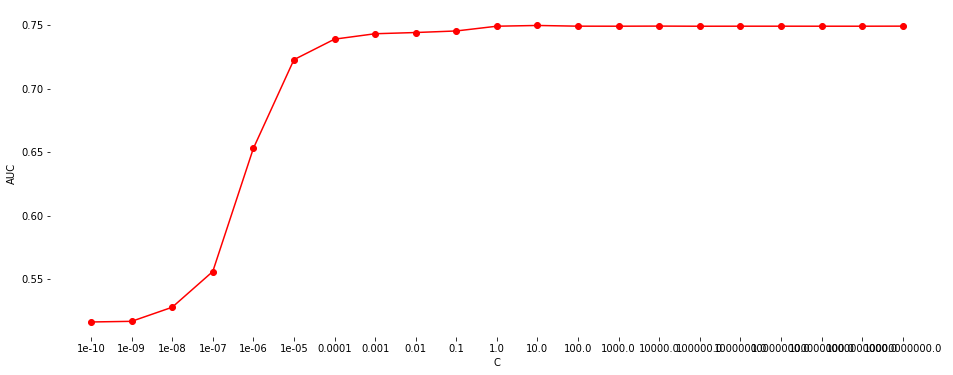

LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.7496360559707688


In [28]:
logreg_models = pf.fitModels(LogisticRegression(), logreg_paramGrid, X_train_sl, y_train_sl)
logreg_scores = pf.scoreModels(logreg_models, X_val_sl, y_val_sl, metric=roc_auc_score, predict_proba=True)
pf.plotScores(logreg_scores, logreg_paramGrid, 'AUC')
logreg_bestModel = pf.getBestModel(logreg_models, logreg_scores, greater_is_better=True)
logreg_bestScore = pf.getBestScore(logreg_scores, greater_is_better=True)
print(logreg_bestModel, logreg_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1334s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    1.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:    1.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.0s finished


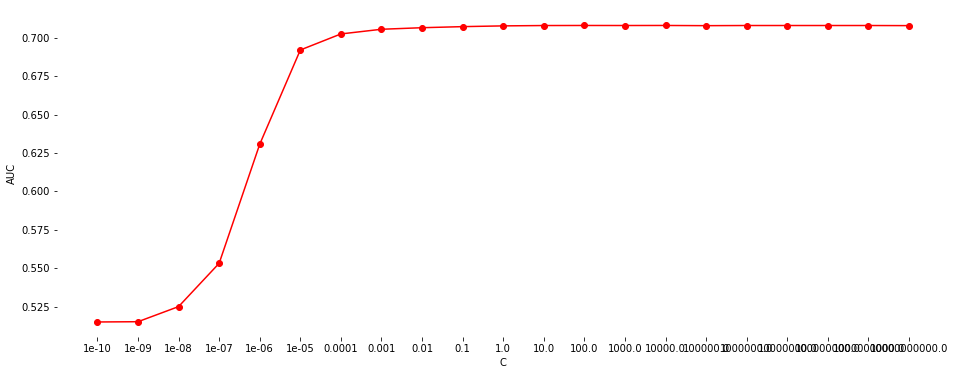

LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.7079291243249815


In [29]:
logreg_models = pf.fitModels(LogisticRegression(), logreg_paramGrid, X_train_ch, y_train_ch)
logreg_scores = pf.scoreModels(logreg_models, X_val_ch, y_val_ch, metric=roc_auc_score, predict_proba=True)
pf.plotScores(logreg_scores, logreg_paramGrid, 'AUC')
logreg_bestModel = pf.getBestModel(logreg_models, logreg_scores, greater_is_better=True)
logreg_bestScore = pf.getBestScore(logreg_scores, greater_is_better=True)
print(logreg_bestModel, logreg_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0321s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of  21 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.0s fi

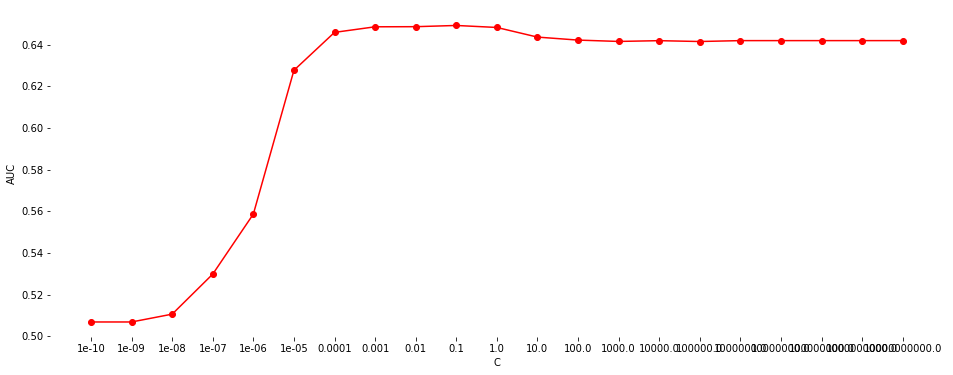

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.6492027814848633


In [30]:
logreg_models = pf.fitModels(LogisticRegression(), logreg_paramGrid, X_train_fc, y_train_fc)
logreg_scores = pf.scoreModels(logreg_models, X_val_fc, y_val_fc, metric=roc_auc_score, predict_proba=True)
pf.plotScores(logreg_scores, logreg_paramGrid, 'AUC')
logreg_bestModel = pf.getBestModel(logreg_models, logreg_scores, greater_is_better=True)
logreg_bestScore = pf.getBestScore(logreg_scores, greater_is_better=True)
print(logreg_bestModel, logreg_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0201s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of  21 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.0s fi

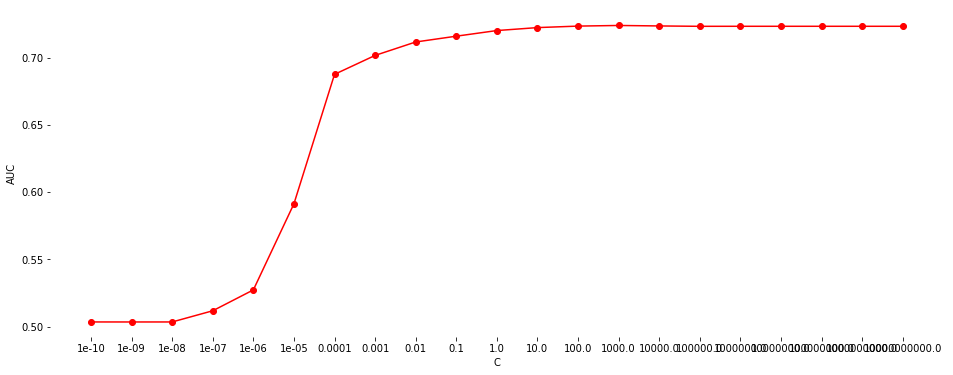

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.7244704882899233


In [31]:
logreg_models = pf.fitModels(LogisticRegression(), logreg_paramGrid, X_train_fs, y_train_fs)
logreg_scores = pf.scoreModels(logreg_models, X_val_fs, y_val_fs, metric=roc_auc_score, predict_proba=True)
pf.plotScores(logreg_scores, logreg_paramGrid, 'AUC')
logreg_bestModel = pf.getBestModel(logreg_models, logreg_scores, greater_is_better=True)
logreg_bestScore = pf.getBestScore(logreg_scores, greater_is_better=True)
print(logreg_bestModel, logreg_bestScore)


In [52]:
clf_grid = {
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto'],
    'n_estimators': [200],
    'n_jobs': [-1],
    'class_weight': ['balanced']}

clf_paramGrid = ParameterGrid(clf_grid)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:  3.9min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  3.9min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  4.0min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  4.0min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  4.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  4.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   13.7s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   27.5s finished


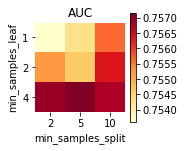

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 0.7571603548226925


In [47]:
clf_models = pf.fitModels(RandomForestClassifier(), clf_paramGrid, X_train, y_train)
clf_scores = pf.scoreModels(clf_models, X_val, y_val, metric=roc_auc_score, predict_proba=True)
pf.plotScores(clf_scores, clf_paramGrid, 'AUC')
clf_bestModel = pf.getBestModel(clf_models, clf_scores, greater_is_better=True)
clf_bestScore = pf.getBestScore(clf_scores, greater_is_better=True)
print(clf_bestModel, clf_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:  1.4min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  1.4min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  1.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.5min remaining:   44.0s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.5min remaining:   25.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    7.8s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.3s finished


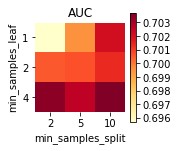

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 0.7037012781238222


In [53]:
clf_models = pf.fitModels(RandomForestClassifier(), clf_paramGrid, X_train_fa, y_train_fa)
clf_scores = pf.scoreModels(clf_models, X_val_fa, y_val_fa, metric=roc_auc_score, predict_proba=True)
pf.plotScores(clf_scores, clf_paramGrid, 'AUC')
clf_bestModel = pf.getBestModel(clf_models, clf_scores, greater_is_better=True)
clf_bestScore = pf.getBestScore(clf_scores, greater_is_better=True)
print(clf_bestModel, clf_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   27.4s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   27.9s remaining:   55.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   28.5s remaining:   35.6s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   29.1s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   29.4s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   29.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   31.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    4.1s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    7.3s finished


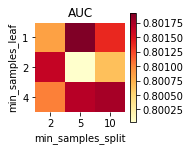

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 0.8019221326229848


In [38]:
clf_models = pf.fitModels(RandomForestClassifier(), clf_paramGrid, X_train_cu, y_train_cu)
clf_scores = pf.scoreModels(clf_models, X_val_cu, y_val_cu, metric=roc_auc_score, predict_proba=True)
pf.plotScores(clf_scores, clf_paramGrid, 'AUC')
clf_bestModel = pf.getBestModel(clf_models, clf_scores, greater_is_better=True)
clf_bestScore = pf.getBestScore(clf_scores, greater_is_better=True)
print(clf_bestModel, clf_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   47.4s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   48.6s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   49.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   50.6s remaining:   40.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   52.0s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   52.9s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   54.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   54.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    7.6s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.2s finished


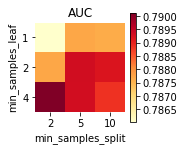

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 0.7901161013329492


In [39]:
clf_models = pf.fitModels(RandomForestClassifier(), clf_paramGrid, X_train_sl, y_train_sl)
clf_scores = pf.scoreModels(clf_models, X_val_sl, y_val_sl, metric=roc_auc_score, predict_proba=True)
pf.plotScores(clf_scores, clf_paramGrid, 'AUC')
clf_bestModel = pf.getBestModel(clf_models, clf_scores, greater_is_better=True)
clf_bestScore = pf.getBestScore(clf_scores, greater_is_better=True)
print(clf_bestModel, clf_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   33.3s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   34.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   36.5s remaining:   45.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   36.9s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   37.4s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   38.1s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   39.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   39.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    5.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    8.5s finished


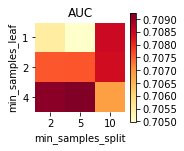

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 0.7092385444061211


In [40]:
clf_models = pf.fitModels(RandomForestClassifier(), clf_paramGrid, X_train_ch, y_train_ch)
clf_scores = pf.scoreModels(clf_models, X_val_ch, y_val_ch, metric=roc_auc_score, predict_proba=True)
pf.plotScores(clf_scores, clf_paramGrid, 'AUC')
clf_bestModel = pf.getBestModel(clf_models, clf_scores, greater_is_better=True)
clf_bestScore = pf.getBestScore(clf_scores, greater_is_better=True)
print(clf_bestModel, clf_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    7.8s remaining:   27.4s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    8.5s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    8.7s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    8.8s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    9.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    9.1s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.0s finished


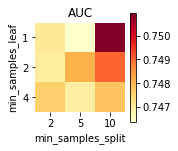

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 0.7509596473976258


In [41]:
clf_models = pf.fitModels(RandomForestClassifier(), clf_paramGrid, X_train_fc, y_train_fc)
clf_scores = pf.scoreModels(clf_models, X_val_fc, y_val_fc, metric=roc_auc_score, predict_proba=True)
pf.plotScores(clf_scores, clf_paramGrid, 'AUC')
clf_bestModel = pf.getBestModel(clf_models, clf_scores, greater_is_better=True)
clf_bestScore = pf.getBestScore(clf_scores, greater_is_better=True)
print(clf_bestModel, clf_bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.7s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    2.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    3.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    3.1s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    3.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    3.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.0s finished


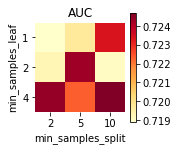

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 0.7247021798312513


In [42]:
clf_models = pf.fitModels(RandomForestClassifier(), clf_paramGrid, X_train_fs, y_train_fs)
clf_scores = pf.scoreModels(clf_models, X_val_fs, y_val_fs, metric=roc_auc_score, predict_proba=True)
pf.plotScores(clf_scores, clf_paramGrid, 'AUC')
clf_bestModel = pf.getBestModel(clf_models, clf_scores, greater_is_better=True)
clf_bestScore = pf.getBestScore(clf_scores, greater_is_better=True)
print(clf_bestModel, clf_bestScore)

In [463]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter = sidx)]

In [464]:
logreg = LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg.fit(X_train,y_train)

rfecv_log = RFECV(logreg,step=1,cv=5)
rfecv_log.fit(X_train,y_train)

RFECV(cv=5,
   estimator=LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Features Selected: 6

Features Indexes: 
['0', '4', '6', '9', '12', '15']

Feature Names: 
['start_speed_corr', 'pfx_z_corr', 'pz_corr_new', 'z0_corr', 'vz0_corr', 'az_corr']


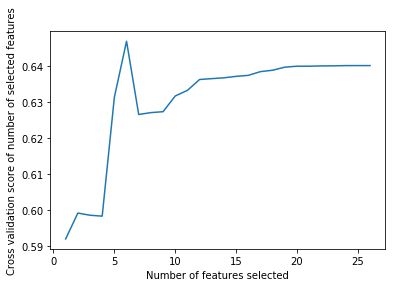

In [465]:
feature_index_log = []
features_log = []
column_index(X_train, X_train.columns.values)

for num, i in enumerate(rfecv_log.get_support(), start=0):
    if i == True:
        feature_index_log.append(str(num))

for num, i in enumerate(X_train.columns.values, start=0):
    if str(num) in feature_index_log:
        features_log.append(X_train.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index_log)))
print("Features Indexes: \n{}\n".format(feature_index_log))
print("Feature Names: \n{}".format(features_log))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv_log.grid_scores_) + 1), rfecv_log.grid_scores_)
plt.show()

In [466]:
logreg_fa = LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_fa.fit(X_train_fa,y_train_fa)

rfecv_log_fa = RFECV(logreg,step=1,cv=5)
rfecv_log_fa.fit(X_train_fa,y_train_fa)

RFECV(cv=5,
   estimator=LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Features Selected: 14

Features Indexes: 
['0', '3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16']

Feature Names: 
['start_speed_corr', 'pfx_x_corr', 'pfx_z_corr', 'px_corr_new', 'pz_corr_new', 'x0_corr', 'z0_corr', 'vx0_corr', 'vy0_corr', 'vz0_corr', 'ax_corr', 'ay_corr', 'az_corr', 'spin_rate']


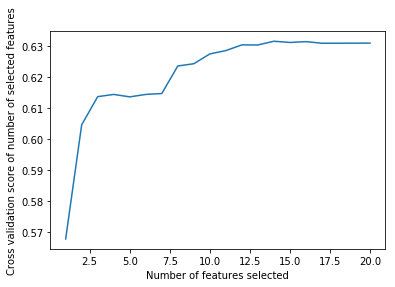

In [467]:
feature_index_log_fa = []
features_log_fa = []
column_index(X_train_fa, X_train_fa.columns.values)

for num, i in enumerate(rfecv_log_fa.get_support(), start=0):
    if i == True:
        feature_index_log_fa.append(str(num))

for num, i in enumerate(X_train_fa.columns.values, start=0):
    if str(num) in feature_index_log_fa:
        features_log_fa.append(X_train_fa.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index_log_fa)))
print("Features Indexes: \n{}\n".format(feature_index_log_fa))
print("Feature Names: \n{}".format(features_log_fa))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv_log_fa.grid_scores_) + 1), rfecv_log_fa.grid_scores_)
plt.show()

In [468]:
logreg_cu = LogisticRegression(C=1000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_cu.fit(X_train_cu,y_train_cu)

rfecv_log_cu = RFECV(logreg_cu,step=1,cv=5)
rfecv_log_cu.fit(X_train_cu,y_train_cu)

RFECV(cv=5,
   estimator=LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Features Selected: 14

Features Indexes: 
['0', '1', '3', '5', '6', '7', '9', '10', '11', '12', '14', '17', '18', '19']

Feature Names: 
['start_speed_corr', 'top_zone', 'pfx_x_corr', 'px_corr_new', 'pz_corr_new', 'x0_corr', 'z0_corr', 'vx0_corr', 'vy0_corr', 'vz0_corr', 'ay_corr', 'throws', 'stand', 'home_Coors']


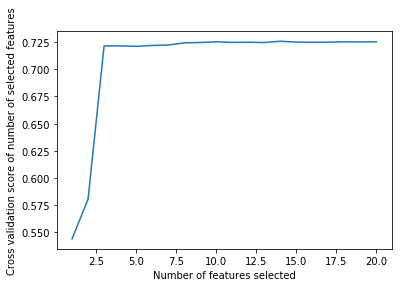

In [469]:
feature_index_log_cu = []
features_log_cu = []
column_index(X_train_cu, X_train_cu.columns.values)

for num, i in enumerate(rfecv_log_cu.get_support(), start=0):
    if i == True:
        feature_index_log_cu.append(str(num))

for num, i in enumerate(X_train_cu.columns.values, start=0):
    if str(num) in feature_index_log_cu:
        features_log_cu.append(X_train_cu.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index_log_cu)))
print("Features Indexes: \n{}\n".format(feature_index_log_cu))
print("Feature Names: \n{}".format(features_log_cu))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv_log_cu.grid_scores_) + 1), rfecv_log_cu.grid_scores_)
plt.show()

In [470]:
logreg_sl = LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_sl.fit(X_train_sl,y_train_sl)

rfecv_log_sl = RFECV(logreg_sl,step=1,cv=5)
rfecv_log_sl.fit(X_train_sl,y_train_sl)

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Features Selected: 13

Features Indexes: 
['0', '1', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15']

Feature Names: 
['start_speed_corr', 'top_zone', 'pfx_z_corr', 'px_corr_new', 'pz_corr_new', 'x0_corr', 'z0_corr', 'vx0_corr', 'vy0_corr', 'vz0_corr', 'ax_corr', 'ay_corr', 'az_corr']


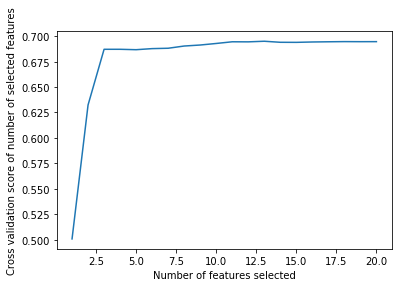

In [471]:
feature_index_log_sl = []
features_log_sl = []
column_index(X_train_sl, X_train_sl.columns.values)

for num, i in enumerate(rfecv_log_sl.get_support(), start=0):
    if i == True:
        feature_index_log_sl.append(str(num))

for num, i in enumerate(X_train_sl.columns.values, start=0):
    if str(num) in feature_index_log_sl:
        features_log_sl.append(X_train_sl.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index_log_sl)))
print("Features Indexes: \n{}\n".format(feature_index_log_sl))
print("Feature Names: \n{}".format(features_log_sl))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv_log_sl.grid_scores_) + 1), rfecv_log_sl.grid_scores_)
plt.show()

In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf.fit(X_train,y_train)

rfecv_clf = RFECV(clf,step=1,cv=5)
rfecv_clf.fit(X_train,y_train)

In [ ]:
feature_index_clf = []
features_clf = []
column_index(X_train_cu, X_train_cu.columns.values)

for num, i in enumerate(rfecv_clf.get_support(), start=0):
    if i == True:
        feature_index_clf.append(str(num))

for num, i in enumerate(X_train_cu.columns.values, start=0):
    if str(num) in feature_index_clf:
        features_clf.append(X_train_cu.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index_clf)))
print("Features Indexes: \n{}\n".format(feature_index_clf))
print("Feature Names: \n{}".format(features_clf))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv_clf.grid_scores_) + 1), rfecv_clf.grid_scores_)
plt.show()

In [474]:
clf_fa = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_fa.fit(X_train_fa,y_train_fa)

rfecv_clf_fa = RFECV(clf,step=1,cv=5)
rfecv_clf_fa.fit(X_train_fa,y_train_fa)

RFECV(cv=5,
   estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Features Selected: 19

Features Indexes: 
['0', '1', '2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

Feature Names: 
['start_speed_corr', 'top_zone', 'bot_zone', 'pfx_x_corr', 'pfx_z_corr', 'px_corr_new', 'pz_corr_new', 'x0_corr', 'z0_corr', 'vx0_corr', 'vy0_corr', 'vz0_corr', 'ax_corr', 'ay_corr', 'az_corr', 'spin_rate', 'throws', 'stand', 'home_Coors']


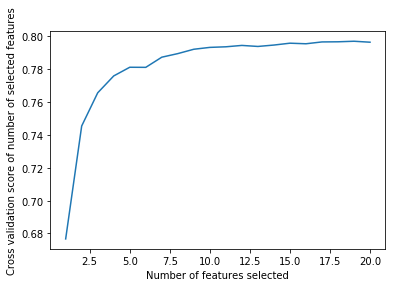

In [475]:
feature_index_clf_fa = []
features_clf_fa = []
column_index(X_train_cu, X_train_cu.columns.values)

for num, i in enumerate(rfecv_clf_fa.get_support(), start=0):
    if i == True:
        feature_index_clf_fa.append(str(num))

for num, i in enumerate(X_train_cu.columns.values, start=0):
    if str(num) in feature_index_clf_fa:
        features_clf_fa.append(X_train_cu.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index_clf_fa)))
print("Features Indexes: \n{}\n".format(feature_index_clf_fa))
print("Feature Names: \n{}".format(features_clf_fa))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv_clf_fa.grid_scores_) + 1), rfecv_clf_fa.grid_scores_)
plt.show()


In [476]:
clf_cu = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_cu.fit(X_train_cu,y_train_cu)

rfecv_clf_cu = RFECV(clf_cu,step=1,cv=5)
rfecv_clf_cu.fit(X_train_cu,y_train_cu)

RFECV(cv=5,
   estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Features Selected: 19

Features Indexes: 
['0', '1', '2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

Feature Names: 
['start_speed_corr', 'top_zone', 'bot_zone', 'pfx_x_corr', 'pfx_z_corr', 'px_corr_new', 'pz_corr_new', 'x0_corr', 'z0_corr', 'vx0_corr', 'vy0_corr', 'vz0_corr', 'ax_corr', 'ay_corr', 'az_corr', 'spin_rate', 'throws', 'stand', 'home_Coors']


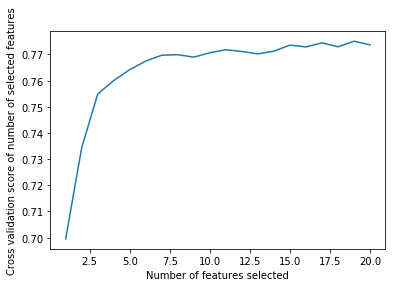

In [477]:
feature_index_clf_cu = []
features_clf_cu = []
column_index(X_train_cu, X_train_cu.columns.values)

for num, i in enumerate(rfecv_clf_cu.get_support(), start=0):
    if i == True:
        feature_index_clf_cu.append(str(num))

for num, i in enumerate(X_train_cu.columns.values, start=0):
    if str(num) in feature_index_clf_cu:
        features_clf_cu.append(X_train_cu.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index_clf_cu)))
print("Features Indexes: \n{}\n".format(feature_index_clf_cu))
print("Feature Names: \n{}".format(features_clf_cu))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv_clf_cu.grid_scores_) + 1), rfecv_clf_cu.grid_scores_)
plt.show()

In [478]:
clf_sl = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_sl.fit(X_train_sl,y_train_sl)

rfecv_clf_sl = RFECV(clf,step=1,cv=5)
rfecv_clf_sl.fit(X_train_sl,y_train_sl)

RFECV(cv=5,
   estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Features Selected: 17

Features Indexes: 
['0', '1', '2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '18']

Feature Names: 
['start_speed_corr', 'top_zone', 'bot_zone', 'pfx_x_corr', 'pfx_z_corr', 'px_corr_new', 'pz_corr_new', 'x0_corr', 'z0_corr', 'vx0_corr', 'vy0_corr', 'vz0_corr', 'ax_corr', 'ay_corr', 'az_corr', 'spin_rate', 'stand']


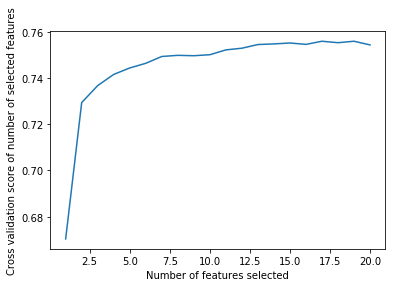

In [479]:
feature_index_clf_sl = []
features_clf_sl = []
column_index(X_train_sl, X_train_sl.columns.values)

for num, i in enumerate(rfecv_clf_sl.get_support(), start=0):
    if i == True:
        feature_index_clf_sl.append(str(num))

for num, i in enumerate(X_train_sl.columns.values, start=0):
    if str(num) in feature_index_clf_sl:
        features_clf_sl.append(X_train_sl.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index_clf_sl)))
print("Features Indexes: \n{}\n".format(feature_index_clf_sl))
print("Feature Names: \n{}".format(features_clf_sl))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv_clf_sl.grid_scores_) + 1), rfecv_clf_sl.grid_scores_)
plt.show()

In [80]:
logreg = LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg.fit(X_train,y_train)

LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [82]:
y_pred_log = logreg.predict(X_val)
#y_pred_class = binarize(y_pred_log, optimal_threshold_log)
r2_log = logreg.score(X_val, y_val)
y_pred_log_prob = logreg.predict_proba(X_val)[:,1]
print(confusion_matrix(y_val,y_pred_log))
print(classification_report(y_val,y_pred_log))
print("Tuned Logistic Regression R squared: {}".format(r2_log))

fpr_log, tpr_log, thresholds = roc_curve(y_val, y_pred_log_prob)
roc_auc_log = roc_auc_score(y_val, y_pred_log_prob)
print("AUC: {}".format(roc_auc_log))

optimal_idx_log = np.argmax(np.abs(tpr_log - fpr_log))
optimal_threshold_log = thresholds[optimal_idx_log]
print("Youden's J Statistic: {}".format(optimal_threshold_log))

[[24716 12037]
 [ 5746  7380]]
             precision    recall  f1-score   support

        0.0       0.81      0.67      0.74     36753
        1.0       0.38      0.56      0.45     13126

avg / total       0.70      0.64      0.66     49879

Tuned Logistic Regression R squared: 0.6434772148599611
AUC: 0.6515640655255089
Youden's J Statistic: 0.5569949836834486


In [83]:
logreg_fa = LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_fa.fit(X_train_fa,y_train_fa)

LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [84]:
y_pred_log_fa = logreg_fa.predict(X_val_fa)
r2_log_fa = logreg_fa.score(X_val_fa, y_val_fa)
y_pred_log_prob_fa = logreg_fa.predict_proba(X_val_fa)[:,1]
print(confusion_matrix(y_val_fa,y_pred_log_fa))
print(classification_report(y_val_fa,y_pred_log_fa))
print("Tuned Logistic Regression R squared: {}".format(r2_log_fa))

fpr_log_fa, tpr_log_fa, thresholds_fa = roc_curve(y_val_fa, y_pred_log_prob_fa)
roc_auc_log_fa = roc_auc_score(y_val_fa, y_pred_log_prob_fa)
print("AUC: {}".format(roc_auc_log_fa))

optimal_idx_log_fa = np.argmax(np.abs(tpr_log_fa - fpr_log_fa))
optimal_threshold_log_fa = thresholds_fa[optimal_idx_log_fa]

print("Youden's J Statistic: {}".format(optimal_threshold_log_fa))

[[12112  7016]
 [ 1769  2944]]
             precision    recall  f1-score   support

        0.0       0.87      0.63      0.73     19128
        1.0       0.30      0.62      0.40      4713

avg / total       0.76      0.63      0.67     23841

Tuned Logistic Regression R squared: 0.6315171343483914
AUC: 0.6680590863272459
Youden's J Statistic: 0.5114950945152067


In [85]:
logreg_cu = LogisticRegression(C=1000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_cu.fit(X_train_cu,y_train_cu)

LogisticRegression(C=1000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [102]:
y_pred_log_cu = logreg_cu.predict(X_val_cu)
r2_log_cu = logreg_cu.score(X_val_cu, y_val_cu)
y_pred_log_prob_cu = logreg_cu.predict_proba(X_val_cu)[:,1]
print(confusion_matrix(y_val_cu,y_pred_log_cu))
print(classification_report(y_val_cu,y_pred_log_cu))
print("Tuned Logistic Regression R squared: {}".format(r2_log_cu))

fpr_log_cu, tpr_log_cu, thresholds_cu = roc_curve(y_val_cu, y_pred_log_prob_cu)
roc_auc_log_cu = roc_auc_score(y_val_cu, y_pred_log_prob_cu)
print("AUC: {}".format(roc_auc_log_cu))

optimal_idx_log_cu = np.argmax(np.abs(tpr_log_cu - fpr_log_cu))
optimal_threshold_log_cu = thresholds_cu[optimal_idx_log_cu]

print("Youden's J Statistic: {}".format(optimal_threshold_log_cu))

print(abs(logreg_cu.coef_))

feature_importance = abs(logreg_cu.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)


[[2679  973]
 [ 463 1259]]
             precision    recall  f1-score   support

        0.0       0.85      0.73      0.79      3652
        1.0       0.56      0.73      0.64      1722

avg / total       0.76      0.73      0.74      5374

Tuned Logistic Regression R squared: 0.7327874953479717
AUC: 0.8008196867291784
Youden's J Statistic: 0.5492926679479967
[[1.71675908e+01 1.77239245e-01 1.88226524e-03 1.08886132e+00
  2.45466678e-01 4.22860690e-01 1.13041397e+00 1.87668238e+00
  0.00000000e+00 1.48860659e-02 1.39454390e+00 1.73548164e+01
  5.09047438e-02 2.60309348e-01 2.31240119e-01 9.00745138e-02
  6.29652837e-02 1.19291179e-01 5.89938200e-05 6.81722461e-02]]
[ 8 18  2  9 12 16 19 15 17  1 14  4 13  5  3  6 10  7  0 11]


In [87]:
logreg_sl = LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_sl.fit(X_train_sl,y_train_sl)

LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [88]:
y_pred_log_sl = logreg_sl.predict(X_val_sl)
r2_log_sl = logreg_sl.score(X_val_sl, y_val_sl)
y_pred_log_prob_sl = logreg_sl.predict_proba(X_val_sl)[:,1]
print(confusion_matrix(y_val_sl,y_pred_log_sl))
print(classification_report(y_val_sl,y_pred_log_sl))
print("Tuned Logistic Regression R squared: {}".format(r2_log_sl))

fpr_log_sl, tpr_log_sl, thresholds_sl = roc_curve(y_val_sl, y_pred_log_prob_sl)
roc_auc_log_sl = roc_auc_score(y_val_sl, y_pred_log_prob_sl)
print("AUC: {}".format(roc_auc_log_sl))

optimal_idx_log_sl = np.argmax(np.abs(tpr_log_sl - fpr_log_sl))
optimal_threshold_log_sl = thresholds_sl[optimal_idx_log_sl]

print("Youden's J Statistic: {}".format(optimal_threshold_log_sl))

[[4582 1963]
 [1036 2475]]
             precision    recall  f1-score   support

        0.0       0.82      0.70      0.75      6545
        1.0       0.56      0.70      0.62      3511

avg / total       0.73      0.70      0.71     10056

Tuned Logistic Regression R squared: 0.7017700875099443
AUC: 0.7612900544594213
Youden's J Statistic: 0.5601605199344311


In [89]:
logreg_ch = LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_ch.fit(X_train_ch,y_train_ch)

LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [90]:
y_pred_log_ch = logreg_ch.predict(X_val_ch)
r2_log_ch = logreg_ch.score(X_val_ch, y_val_ch)
y_pred_log_prob_ch = logreg_ch.predict_proba(X_val_ch)[:,1]
print(confusion_matrix(y_val_ch,y_pred_log_ch))
print(classification_report(y_val_ch,y_pred_log_ch))
print("Tuned Logistic Regression R squared: {}".format(r2_log_ch))

fpr_log_ch, tpr_log_ch, thresholds_ch = roc_curve(y_val_ch, y_pred_log_prob_ch)
roc_auc_log_ch = roc_auc_score(y_val_ch, y_pred_log_prob_ch)
print("AUC: {}".format(roc_auc_log_ch))

optimal_idx_log_ch = np.argmax(np.abs(tpr_log_ch - fpr_log_ch))
optimal_threshold_log_ch = thresholds_ch[optimal_idx_log_ch]

print("Youden's J Statistic: {}".format(optimal_threshold_log_ch))

[[3242 1742]
 [ 761 1457]]
             precision    recall  f1-score   support

        0.0       0.81      0.65      0.72      4984
        1.0       0.46      0.66      0.54      2218

avg / total       0.70      0.65      0.66      7202

Tuned Logistic Regression R squared: 0.6524576506525965
AUC: 0.7043183814898387
Youden's J Statistic: 0.5154524278197855


In [91]:
logreg_fc = LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_fc.fit(X_train_fc,y_train_fc)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [92]:
y_pred_log_fc = logreg_fc.predict(X_val_fc)
r2_log_fc = logreg_fc.score(X_val_fc, y_val_fc)
y_pred_log_prob_fc = logreg_fc.predict_proba(X_val_fc)[:,1]
print(confusion_matrix(y_val_fc,y_pred_log_fc))
print(classification_report(y_val_fc,y_pred_log_fc))
print("Tuned Logistic Regression R squared: {}".format(r2_log_fc))

fpr_log_fc, tpr_log_fc, thresholds_fc = roc_curve(y_val_fc, y_pred_log_prob_fc)
roc_auc_log_fc = roc_auc_score(y_val_fc, y_pred_log_prob_fc)
print("AUC: {}".format(roc_auc_log_fc))

optimal_idx_log_fc = np.argmax(np.abs(tpr_log_fc - fpr_log_fc))
optimal_threshold_log_fc = thresholds_fc[optimal_idx_log_fc]

print("Youden's J Statistic: {}".format(optimal_threshold_log_fc))

[[1151  689]
 [ 258  361]]
             precision    recall  f1-score   support

        0.0       0.82      0.63      0.71      1840
        1.0       0.34      0.58      0.43       619

avg / total       0.70      0.61      0.64      2459

Tuned Logistic Regression R squared: 0.6148840992273282
AUC: 0.6264249841961087
Youden's J Statistic: 0.5655747600562959


In [93]:
logreg_fs = LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_fs.fit(X_train_fs,y_train_fs)

LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [94]:
y_pred_log_fs = logreg_fs.predict(X_val_fs)
r2_log_fs = logreg_fs.score(X_val_fs, y_val_fs)
y_pred_log_prob_fs = logreg_fs.predict_proba(X_val_fs)[:,1]
print(confusion_matrix(y_val_fs,y_pred_log_fs))
print(classification_report(y_val_fs,y_pred_log_fs))
print("Tuned Logistic Regression R squared: {}".format(r2_log_fs))

fpr_log_fs, tpr_log_fs, thresholds_fs = roc_curve(y_val_fs, y_pred_log_prob_fs)
roc_auc_log_fs = roc_auc_score(y_val_fs, y_pred_log_prob_fs)
print("AUC: {}".format(roc_auc_log_fs))

optimal_idx_log_fs = np.argmax(np.abs(tpr_log_fs - fpr_log_fs))
optimal_threshold_log_fs = thresholds_fs[optimal_idx_log_fs]

print("Youden's J Statistic: {}".format(optimal_threshold_log_fs))

[[425 179]
 [108 235]]
             precision    recall  f1-score   support

        0.0       0.80      0.70      0.75       604
        1.0       0.57      0.69      0.62       343

avg / total       0.71      0.70      0.70       947

Tuned Logistic Regression R squared: 0.6969376979936642
AUC: 0.7696696464773233
Youden's J Statistic: 0.5389021483399719


In [93]:
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [96]:
y_pred_clf = clf.predict(X_val)
r2_clf = clf.score(X_val, y_val)
y_pred_clf_prob = clf.predict_proba(X_val)[:,1]
print(confusion_matrix(y_val,y_pred_clf))
print(classification_report(y_val,y_pred_clf))
print("Tuned Random Forest R squared: {}".format(r2_clf))

fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_val, y_pred_clf_prob)
roc_auc_clf = roc_auc_score(y_val, y_pred_clf_prob)
print("AUC: {}".format(roc_auc_clf))

optimal_idx_clf = np.argmax(np.abs(tpr_clf - fpr_clf))
optimal_threshold_clf = thresholds_clf[optimal_idx_clf]

print("Youden's J Statistic: {}".format(optimal_threshold_clf))

importances = list(clf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances]

[[33154  3599]
 [ 7740  5386]]
             precision    recall  f1-score   support

        0.0       0.81      0.90      0.85     36753
        1.0       0.60      0.41      0.49     13126

avg / total       0.76      0.77      0.76     49879

Tuned Random Forest R squared: 0.7726698610637743
AUC: 0.7521832589162092
Youden's J Statistic: 0.35824879362907525
Variable: pz_corr_new Importance: 0.19
Variable: px_corr_new Importance: 0.08
Variable: vz0_corr Importance: 0.07
Variable: pfx_z_corr Importance: 0.06
Variable: az_corr Importance: 0.06
Variable: start_speed_corr Importance: 0.05
Variable: pfx_x_corr Importance: 0.05
Variable: x0_corr Importance: 0.05
Variable: z0_corr Importance: 0.05
Variable: vx0_corr Importance: 0.05
Variable: vy0_corr Importance: 0.05
Variable: ax_corr Importance: 0.05
Variable: ay_corr Importance: 0.05
Variable: spin_rate Importance: 0.05
Variable: top_zone Importance: 0.03
Variable: elevation Importance: 0.03
Variable: bot_zone Importance: 0.02
Variable: s

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [97]:
clf_fa = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_fa.fit(X_train_fa,y_train_fa)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [98]:
y_pred_clf_fa = clf_fa.predict(X_val_fa)
r2_clf_fa = clf_fa.score(X_val_fa, y_val_fa)
y_pred_clf_prob_fa = clf_fa.predict_proba(X_val_fa)[:,1]
print(confusion_matrix(y_val_fa,y_pred_clf_fa))
print(classification_report(y_val_fa,y_pred_clf_fa))
print("Tuned Random Forest R squared: {}".format(r2_clf_fa))

fpr_clf_fa, tpr_clf_fa, thresholds_clf_fa = roc_curve(y_val_fa, y_pred_clf_prob_fa)
roc_auc_clf_fa = roc_auc_score(y_val_fa, y_pred_clf_prob_fa)
print("AUC: {}".format(roc_auc_clf_fa))

optimal_idx_clf_fa = np.argmax(np.abs(tpr_clf_fa - fpr_clf_fa))
optimal_threshold_clf_fa = thresholds_clf_fa[optimal_idx_clf_fa]

print("Youden's J Statistic: {}".format(optimal_threshold_clf_fa))

importances = list(clf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances]

[[17821  1307]
 [ 3589  1124]]
             precision    recall  f1-score   support

        0.0       0.83      0.93      0.88     19128
        1.0       0.46      0.24      0.31      4713

avg / total       0.76      0.79      0.77     23841

Tuned Random Forest R squared: 0.7946394865987165
AUC: 0.7063096565086044
Youden's J Statistic: 0.3030220437063557
Variable: pz_corr_new Importance: 0.19
Variable: px_corr_new Importance: 0.08
Variable: vz0_corr Importance: 0.07
Variable: pfx_z_corr Importance: 0.06
Variable: az_corr Importance: 0.06
Variable: start_speed_corr Importance: 0.05
Variable: pfx_x_corr Importance: 0.05
Variable: x0_corr Importance: 0.05
Variable: z0_corr Importance: 0.05
Variable: vx0_corr Importance: 0.05
Variable: vy0_corr Importance: 0.05
Variable: ax_corr Importance: 0.05
Variable: ay_corr Importance: 0.05
Variable: spin_rate Importance: 0.05
Variable: top_zone Importance: 0.03
Variable: elevation Importance: 0.03
Variable: bot_zone Importance: 0.02
Variable: st

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [99]:
clf_cu = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_cu.fit(X_train_cu,y_train_cu)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [100]:
y_pred_clf_cu = clf_cu.predict(X_val_cu)
r2_clf_cu = clf_cu.score(X_val_cu, y_val_cu)
y_pred_clf_prob_cu = clf_cu.predict_proba(X_val_cu)[:,1]
print(confusion_matrix(y_val_cu,y_pred_clf_cu))
print(classification_report(y_val_cu,y_pred_clf_cu))
print("Tuned Random Forest R squared: {}".format(r2_clf_cu))

fpr_clf_cu, tpr_clf_cu, thresholds_clf_cu = roc_curve(y_val_cu, y_pred_clf_prob_cu)
roc_auc_clf_cu = roc_auc_score(y_val_cu, y_pred_clf_prob_cu)
print("AUC: {}".format(roc_auc_clf_cu))

optimal_idx_clf_cu = np.argmax(np.abs(tpr_clf_cu - fpr_clf_cu))
optimal_threshold_clf_cu = thresholds_clf_cu[optimal_idx_clf_cu]

print("Youden's J Statistic: {}".format(optimal_threshold_clf_cu))

importances = list(clf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances]

[[3296  356]
 [ 829  893]]
             precision    recall  f1-score   support

        0.0       0.80      0.90      0.85      3652
        1.0       0.71      0.52      0.60      1722

avg / total       0.77      0.78      0.77      5374

Tuned Random Forest R squared: 0.7794938593226647
AUC: 0.8028188140588963
Youden's J Statistic: 0.3739366364527404
Variable: pz_corr_new Importance: 0.19
Variable: px_corr_new Importance: 0.08
Variable: vz0_corr Importance: 0.07
Variable: pfx_z_corr Importance: 0.06
Variable: az_corr Importance: 0.06
Variable: start_speed_corr Importance: 0.05
Variable: pfx_x_corr Importance: 0.05
Variable: x0_corr Importance: 0.05
Variable: z0_corr Importance: 0.05
Variable: vx0_corr Importance: 0.05
Variable: vy0_corr Importance: 0.05
Variable: ax_corr Importance: 0.05
Variable: ay_corr Importance: 0.05
Variable: spin_rate Importance: 0.05
Variable: top_zone Importance: 0.03
Variable: elevation Importance: 0.03
Variable: bot_zone Importance: 0.02
Variable: stand 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [101]:
clf_sl = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_sl.fit(X_train_sl,y_train_sl)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [102]:
y_pred_clf_sl = clf_sl.predict(X_val_sl)
r2_clf_sl = clf_sl.score(X_val_sl, y_val_sl)
y_pred_clf_prob_sl = clf_sl.predict_proba(X_val_sl)[:,1]
print(confusion_matrix(y_val_sl,y_pred_clf_sl))
print(classification_report(y_val_sl,y_pred_clf_sl))
print("Tuned Random Forest R squared: {}".format(r2_clf_sl))

fpr_clf_sl, tpr_clf_sl, thresholds_clf_sl = roc_curve(y_val_sl, y_pred_clf_prob_sl)
roc_auc_clf_sl = roc_auc_score(y_val_sl, y_pred_clf_prob_sl)
print("AUC: {}".format(roc_auc_clf_sl))

optimal_idx_clf_sl = np.argmax(np.abs(tpr_clf_sl - fpr_clf_sl))
optimal_threshold_clf_sl = thresholds_clf_sl[optimal_idx_clf_sl]

print("Youden's J Statistic: {}".format(optimal_threshold_clf_sl))

importances = list(clf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances]

[[5617  928]
 [1491 2020]]
             precision    recall  f1-score   support

        0.0       0.79      0.86      0.82      6545
        1.0       0.69      0.58      0.63      3511

avg / total       0.75      0.76      0.75     10056

Tuned Random Forest R squared: 0.7594470962609388
AUC: 0.7898388976781257
Youden's J Statistic: 0.406936901542186
Variable: pz_corr_new Importance: 0.19
Variable: px_corr_new Importance: 0.08
Variable: vz0_corr Importance: 0.07
Variable: pfx_z_corr Importance: 0.06
Variable: az_corr Importance: 0.06
Variable: start_speed_corr Importance: 0.05
Variable: pfx_x_corr Importance: 0.05
Variable: x0_corr Importance: 0.05
Variable: z0_corr Importance: 0.05
Variable: vx0_corr Importance: 0.05
Variable: vy0_corr Importance: 0.05
Variable: ax_corr Importance: 0.05
Variable: ay_corr Importance: 0.05
Variable: spin_rate Importance: 0.05
Variable: top_zone Importance: 0.03
Variable: elevation Importance: 0.03
Variable: bot_zone Importance: 0.02
Variable: stand I

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [74]:
clf_ch = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_ch.fit(X_train_ch,y_train_ch)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [75]:
y_pred_clf_ch = clf_ch.predict(X_val_ch)
r2_clf_ch = clf_ch.score(X_val_ch, y_val_ch)
y_pred_clf_prob_ch = clf_ch.predict_proba(X_val_ch)[:,1]
print(confusion_matrix(y_val_ch,y_pred_clf_ch))
print(classification_report(y_val_ch,y_pred_clf_ch))
print("Tuned Random Forest R squared: {}".format(r2_clf_ch))

fpr_clf_ch, tpr_clf_ch, thresholds_clf_ch = roc_curve(y_val_ch, y_pred_clf_prob_ch)
roc_auc_clf_ch = roc_auc_score(y_val_ch, y_pred_clf_prob_ch)
print("AUC: {}".format(roc_auc_clf_ch))

optimal_idx_clf_ch = np.argmax(np.abs(tpr_clf_ch - fpr_clf_ch))
optimal_threshold_clf_ch = thresholds_clf_ch[optimal_idx_clf_ch]

print("Youden's J Statistic: {}".format(optimal_threshold_clf_ch))

[[4330  654]
 [1345  873]]
             precision    recall  f1-score   support

        0.0       0.76      0.87      0.81      4984
        1.0       0.57      0.39      0.47      2218

avg / total       0.70      0.72      0.71      7202

Tuned Random Forest R squared: 0.7224382116078867
AUC: 0.7046398791733186
Youden's J Statistic: 0.37026916534565313


In [76]:
clf_fc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_fc.fit(X_train_fc,y_train_fc)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [77]:
y_pred_clf_fc = clf_fc.predict(X_val_fc)
r2_clf_fc = clf_fc.score(X_val_fc, y_val_fc)
y_pred_clf_prob_fc = clf_fc.predict_proba(X_val_fc)[:,1]
print(confusion_matrix(y_val_fc,y_pred_clf_fc))
print(classification_report(y_val_fc,y_pred_clf_fc))
print("Tuned Random Forest R squared: {}".format(r2_clf_fc))

fpr_clf_fc, tpr_clf_fc, thresholds_clf_fc = roc_curve(y_val_fc, y_pred_clf_prob_fc)
roc_auc_clf_fc = roc_auc_score(y_val_fc, y_pred_clf_prob_fc)
print("AUC: {}".format(roc_auc_clf_fc))

optimal_idx_clf_fc = np.argmax(np.abs(tpr_clf_fc - fpr_clf_fc))
optimal_threshold_clf_fc = thresholds_clf_fc[optimal_idx_clf_fc]

print("Youden's J Statistic: {}".format(optimal_threshold_clf_fc))

[[1722  118]
 [ 404  215]]
             precision    recall  f1-score   support

        0.0       0.81      0.94      0.87      1840
        1.0       0.65      0.35      0.45       619

avg / total       0.77      0.79      0.76      2459

Tuned Random Forest R squared: 0.7877185847905652
AUC: 0.7406862400786682
Youden's J Statistic: 0.35016597744018463


In [78]:
clf_fs = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf_fs.fit(X_train_fs,y_train_fs)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [79]:
y_pred_clf_fs = clf_fs.predict(X_val_fs)
r2_clf_fs = clf_fs.score(X_val_fs, y_val_fs)
y_pred_clf_prob_fs = clf_fs.predict_proba(X_val_fs)[:,1]
print(confusion_matrix(y_val_fs,y_pred_clf_fs))
print(classification_report(y_val_fs,y_pred_clf_fs))
print("Tuned Random Forest R squared: {}".format(r2_clf_fs))

fpr_clf_fs, tpr_clf_fs, thresholds_clf_fs = roc_curve(y_val_fs, y_pred_clf_prob_fs)
roc_auc_clf_fs = roc_auc_score(y_val_fs, y_pred_clf_prob_fs)
print("AUC: {}".format(roc_auc_clf_fs))

optimal_idx_clf_fs = np.argmax(np.abs(tpr_clf_fs - fpr_clf_fs))
optimal_threshold_clf_fs = thresholds_clf_fs[optimal_idx_clf_fs]

print("Youden's J Statistic: {}".format(optimal_threshold_clf_fs))

[[513  91]
 [162 181]]
             precision    recall  f1-score   support

        0.0       0.76      0.85      0.80       604
        1.0       0.67      0.53      0.59       343

avg / total       0.73      0.73      0.72       947

Tuned Random Forest R squared: 0.7328405491024287
AUC: 0.7673237696213774
Youden's J Statistic: 0.42954544135384065
